In [1]:
import numpy as np
import copy
import numpy.ma as ma
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score
import time
from sklearn import cluster
import nimfa  # non-negative matrix factorization
from statistics import median, mean

#functions
def save_approx(name_of_the_list, approx, i):
    if i == 3:  # save only approx rank 3
        name_of_the_list.append(approx)

import sys
sys.path.append("..")
import utils as ut
import distance_correlation as dc
import STMF as stmf  # sparse tropical matrix factorization

/home/amra/miniconda3/envs/NMF_vs_TMF/lib/python3.6/site-packages/nimfa/examples/cbcl_images.py:98: UserWarning: PIL must be installed to run CBCL images example.
  warn("PIL must be installed to run CBCL images example.")
/home/amra/miniconda3/envs/NMF_vs_TMF/lib/python3.6/site-packages/nimfa/examples/orl_images.py:110: UserWarning: PIL must be installed to run ORL images example.
  warn("PIL must be installed to run ORL images example.")


In [2]:
m = 170 # patients  
n = 100 # genes  
missing_value = 0  # 99 is better than 0, because 0 can be the real value in data; we set missing value to be
# 0 since NMF skips 0s!
epsilon = 0.0000001
temp = 4  # 11
repeat = 5  # 5
max_iter = 500
sparsity = 0.2  # 20%
init = 'nndsvd'  # random, random_c, random_vcol, nndsvd
init_stmf = 'random_vcol'
folder_name = "AML"

# importing data
original_data = np.genfromtxt('../multi_omic/AML/AML_gene_subset.txt', delimiter='\t').T
original_data = np.delete(original_data, 0, axis=0)
original_data = np.delete(original_data, 0, axis=1)

# feature agglomeration columns
agglo = cluster.FeatureAgglomeration(n_clusters=100)
agglo.fit(original_data)
original_data = agglo.transform(original_data)

# polo
original_data, _, _ = ut.polo_clustering(original_data)

original_data += epsilon  
ut.check_zeros(original_data)
data = copy.deepcopy(original_data)

data = ut.create_matrix_with_missing_values(data, sparsity, missing_value)  # create matrix with missing values
data_missing = copy.deepcopy(data)
data = ma.masked_equal(data, missing_value)  # create masked array
print(original_data.shape)

(170, 100)


In [3]:
# PMF
print("PMF")
errors_pmf, corr_pmf, rmse_pmf, time_pmf = np.array([]), np.array([]), np.array([]), np.array([])
approx_pmf = []
U_pmf, V_pmf = 0, 0
for i in range(1, temp):
    error_iter, corr_iter, rmse_iter = np.array([]), np.array([]), np.array([])
    correlations, approximations = [], []
    model = nimfa.Pmf(data, rank=i, max_iter=max_iter, seed=init)
    start_time_pmf = time.time()
    pmf = model()
    t_pmf = round(time.time() - start_time_pmf, 3)
    approx = np.dot(pmf.basis(), pmf.coef(idx=None))
    if i == 3:  # rank 3, all approximations of rank 3 are the same since nndsvd is non-randomized
        U_pmf = pmf.basis()
        V_pmf = pmf.coef(idx=None)
    error_iter = np.append(error_iter, ut.rmse(original_data, data_missing, approx, missing_value))
    correlation, a, b = dc.dcor(original_data, approx)
    if i==3:
        print("rank " + str(i) + ": " + str(correlation))
    corr_iter = np.append(corr_iter, correlation)
    correlations.append(correlation)
    approximations.append(approx)
    rmse_iter = np.append(rmse_iter, ut.rmse_approx(original_data, data_missing, approx, missing_value))
    save_approx(approx_pmf, approximations[np.argmax(correlations)], i)
    errors_pmf, corr_pmf, rmse_pmf, time_pmf = np.append(errors_pmf, error_iter), np.append(corr_pmf, corr_iter), np.append(rmse_pmf, rmse_iter), np.append(time_pmf, t_pmf)

PMF
rank 3: 0.6225203206779196


In [4]:
time_pmf[2]

0.047

In [5]:
# NMF
print("NMF")
errors_nmf, corr_nmf, rmse_nmf, time_nmf = np.array([]), np.array([]), np.array([]), np.array([])
approx_nmf = []
U_nmf, V_nmf = 0, 0
for i in range(1, temp):
    error_iter, corr_iter, rmse_iter = np.array([]), np.array([]), np.array([])
    correlations, approximations = [], []
    model = nimfa.Nmf(data, rank=i, max_iter=max_iter, seed=init)
    start_time_nmf = time.time()
    nmf = model()
    t_nmf = round(time.time() - start_time_nmf, 3)
    approx = np.dot(nmf.basis(), nmf.coef(idx=None))
    if i == 3:  # rank 3, all approximations of rank 3 are the same since nndsvd is non-randomized
        U_nmf = nmf.basis()
        V_nmf = nmf.coef(idx=None)
    error_iter = np.append(error_iter, ut.rmse(original_data, data_missing, approx, missing_value))
    correlation, a, b = dc.dcor(original_data, approx)
    if i==3:
        print("rank " + str(i) + ": " + str(correlation))
    corr_iter = np.append(corr_iter, correlation)
    correlations.append(correlation)
    approximations.append(approx)
    rmse_iter = np.append(rmse_iter, ut.rmse_approx(original_data, data_missing, approx, missing_value))
    save_approx(approx_nmf, approximations[np.argmax(correlations)], i)
    errors_nmf, corr_nmf, rmse_nmf, time_nmf = np.append(errors_nmf, error_iter), np.append(corr_nmf, corr_iter), np.append(rmse_nmf, rmse_iter), np.append(time_nmf, t_nmf)

# STMF
print("STMF")
errors_trop, corr_trop, rmse_trop, time_trop = np.array([]), np.array([]), np.array([]), np.array([])
approx_trop = []
factor_U, factor_V = [], []
U_stmf, V_stmf = 0, 0
for i in range(1, temp):
    error_iter, corr_iter, rmse_iter, time_iter = np.array([]), np.array([]), np.array([]), np.array([])
    correlations, approximations = [], []
    for j in range(0, repeat):
        model = stmf.STMF(rank=i, criterion='iterations', max_iter=max_iter, initialization=init_stmf)
        model.fit(data)
        if i == 3:
            factor_U.append(model.U)
            factor_V.append(model.V)
        approx = model.predict_all()
        error_iter = np.append(error_iter, ut.rmse(original_data, data_missing, approx, missing_value))
        correlation, a, b = dc.dcor(original_data, approx)
        corr_iter = np.append(corr_iter, correlation)
        time_iter = np.append(time_iter, model.time)
        correlations.append(correlation)
        approximations.append(approx)
        rmse_iter = np.append(rmse_iter, ut.rmse_approx(original_data, data_missing, approx, missing_value))
    save_approx(approx_trop, approximations[np.argmax(correlations)], i)
    if i==3:
        print("rank " + str(i) + ", max: " + str(max(correlations)))
        print("rank " + str(i) + ", min: " + str(min(correlations)))
        print("rank " + str(i) + ", median: " + str(median(correlations)))
    if i == 3:
        U_stmf, V_stmf = factor_U[np.argmax(correlations)], factor_V[np.argmax(correlations)]
    errors_trop, corr_trop, rmse_trop, time_trop =  np.append(errors_trop, error_iter), np.append(corr_trop, corr_iter), np.append(rmse_trop, rmse_iter), np.append(time_trop, time_iter)

NMF
rank 3: 0.6361180271080001
STMF
rank 3, max: 0.8450082761896213
rank 3, min: 0.6502590689526336
rank 3, median: 0.830777912244548


### VISUALIZATIONS

Approximation matrices

In [6]:
approx_stmf = approx_trop[0]
approx_nmf = approx_nmf[0]
approx_pmf_x = approx_pmf[0]
X_maxplus = data
X_maxplus_orig = original_data

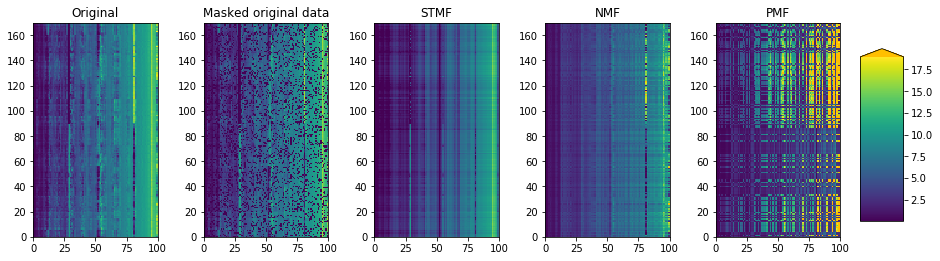

In [7]:
ut.plot_synth_three_methods_origmax(X_maxplus_orig, X_maxplus, approx_stmf, approx_nmf, approx_pmf_x, "", "results/" + folder_name + "/three_methods.png")